## 1. Conexion segura a la base de datos

En este bloque se importan las librerias a utilizar en todo el codigo y configura la conexion con la base de datos PostgreSQL utilizando credenciales seguras almacenadas en un archivo `.env`.  
De esta forma se evita exponer contrasenas directamente en el codigo, siguiendo buenas practicas de seguridad y portabilidad.


In [53]:
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns


load_dotenv()  # Carga las variables definidas en el archivo .env

DB_CONFIG = {
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'database': os.getenv('DB_NAME')
}

DATABASE_URL = (
    f"postgresql+psycopg2://{DB_CONFIG['user']}:{DB_CONFIG['password']}@"
    f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

try:
    engine = create_engine(DATABASE_URL)
    engine.connect()
    print("Conexion a la base de datos exitosa.")
except Exception as e:
    print(f"Error al conectar: {e}")
    engine = None


Conexion a la base de datos exitosa.


## 2. Consulta SQL avanzada (extraccion de datos)

Se ejecuta una consulta SQL que integra las tablas principales del negocio:  
`customer`, `order`, `order_item`, `product`, y `category`.  
El objetivo es construir una vista consolidada con la informacion de clientes, pedidos, productos y categorias, junto con las metricas de ventas (`quantity`, `unit_price`, `item_revenue`).


In [ ]:

SQL_QUERY_AVANZADO = """
SELECT
    c.id_customer,
    c.full_name AS customer_name,
    a.city,
    o.id_order,
    o.created_at AS order_date,
    p.name AS product_name,
    cat.name AS category_name,
    oi.amount AS quantity,
    oi.price AS unit_price,
    (oi.amount * oi.price) AS item_revenue
FROM
    order_item oi
JOIN
    "order" o ON oi.order_id = o.id_order
JOIN
    customer c ON o.customer_id = c.id_customer
JOIN
    address a ON c.address_id = a.id_address
JOIN
    product p ON oi.product_id = p.id_product
JOIN
    category cat ON p.category_id = cat.id_category;
"""


## 3. Limpieza y preparacion de datos

En este bloque se realizan tareas de limpieza minima para asegurar la calidad del conjunto de datos:
- Conversion de fechas al formato correcto (`datetime`).
- Eliminacion de registros duplicados.
- Relleno de valores nulos.  
Estas acciones permiten garantizar la integridad del analisis posterior.


In [ ]:


if engine:
    try:
        df_avanzado = pd.read_sql(text(SQL_QUERY_AVANZADO), engine)
        print(f"Extraccion completa: {len(df_avanzado)} registros cargados.\n")

        if 'order_date' in df_avanzado.columns:
            df_avanzado['order_date'] = pd.to_datetime(df_avanzado['order_date'], errors='coerce')
            print(f"Tipo de 'order_date' convertido a: {df_avanzado['order_date'].dtype}")

        before = len(df_avanzado)
        df_avanzado.drop_duplicates(inplace=True)
        after = len(df_avanzado)
        if before != after:
            print(f" {before - after} registros duplicados eliminados.")

        df_avanzado.fillna({
            col: 0 if df_avanzado[col].dtype.kind in 'biufc' else ''
            for col in df_avanzado.columns if df_avanzado[col].isnull().any()
        }, inplace=True)

        print("Limpieza minima completada.")

    except Exception as e:
        print(f"Error durante la extraccion o limpieza: {e}")
        df_avanzado = pd.DataFrame()
else:
    df_avanzado = pd.DataFrame()
    print("No se pudo establecer conexion con la base de datos.")








Extraccion completa: 1496 registros cargados.

Tipo de 'order_date' convertido a: datetime64[ns, UTC]
Limpieza minima completada.


## 4. Visualizacion de resultados iniciales

Se muestra una vista previa de los datos extraidos (`df_avanzado.head()`),  
verificando que la consulta SQL y la limpieza se realizaron correctamente.  
Esto permite observar las principales columnas disponibles para los analisis exploratorios siguientes.


In [57]:

if not df_avanzado.empty:
    print("\n Vista previa de datos:")
    print(df_avanzado.head())
else:
    print("\n No se cargaron datos.")


 Vista previa de datos:
   id_customer       customer_name         city   id_order         order_date               product_name        \
0      50       Miguel Fernández Gonz...  Itagüí      1    2025-09-25 16:19:48.26...  Raqueta Wilson Pro 33...   
1      50       Miguel Fernández Gonz...  Itagüí      1    2025-09-25 16:19:48.26...  Guayos Adidas Sport 2...   
2      50       Miguel Fernández Gonz...  Itagüí      1    2025-09-25 16:19:48.26...  Raqueta Head Professi...   
3      50       Miguel Fernández Gonz...  Itagüí      1    2025-09-25 16:19:48.26...  Guayos Puma Training ...   
4      50       Miguel Fernández Gonz...  Itagüí      1    2025-09-25 16:19:48.26...  Medias Adidas Competi...   

  category_name  quantity  unit_price  item_revenue  
0      Fitness       3       158.00        474.00    
1   Baloncesto       3       383.00      1,149.00    
2        Tenis       1       190.00        190.00    
3      Fitness       2       381.00        762.00    
4       Fútbol      

## 6. Analisis de tendencia central del gasto

En este bloque se calcula la tendencia central del gasto realizado por pedido y por cliente.  
Para ello se agrupan los datos del conjunto `df_avanzado` sumando el total de ingresos (`item_revenue`) por cada combinacion de pedido y cliente.  
Posteriormente se obtienen las principales medidas de tendencia central:
- **Media**: promedio general del gasto.
- **Mediana**: valor central de la distribucion del gasto.
- **Moda**: gasto que se repite con mayor frecuencia.  

Estos indicadores permiten entender el comportamiento promedio de compra y la dispersion de los montos gastados por los clientes.

In [63]:
if not df_avanzado.empty:
    
    # Crear un DataFrame con el gasto total por pedido y cliente
    gasto_df = df_avanzado.groupby(['id_order', 'id_customer'], as_index=False).agg(
        total_gasto=('item_revenue', 'sum')
    )

    # Calcular medidas de tendencia central
    media_gasto = gasto_df['total_gasto'].mean()
    mediana_gasto = gasto_df['total_gasto'].median()
    moda_gasto = gasto_df['total_gasto'].mode()[0] if not gasto_df['total_gasto'].mode().empty else None

    print("\n--- Tendencia Central del Gasto (por pedido/cliente) ---")
    print(f"        Media del gasto:   {media_gasto:.2f}")
    print(f"        Mediana del gasto: {mediana_gasto:.2f}")
    print(f"        Moda del gasto:    {moda_gasto:.2f}" if moda_gasto is not None else "Moda del gasto: No disponible")
   



--- Tendencia Central del Gasto (por pedido/cliente) ---
        Media del gasto:   1592.00
        Mediana del gasto: 1470.00
        Moda del gasto:    804.00


## 7. Analisis de dispersion del gasto

En este bloque se analizan las medidas de dispersion del gasto total por pedido y cliente.  
Estas medidas complementan las de tendencia central, ya que permiten conocer **cuan dispersos o consistentes** son los montos de gasto entre los pedidos.  

Las metricas calculadas son:
- **Varianza:** mide la variabilidad general del gasto respecto a la media.  
- **Desviacion estandar:** indica en promedio cuanto se aleja cada gasto del valor medio.  
- **Rango intercuartilico (IQR):** refleja la dispersion de los valores centrales, eliminando la influencia de valores extremos.  

Este analisis permite identificar si el comportamiento de gasto de los clientes es homogeneo o si existen grandes diferencias entre pedidos.


In [65]:
if not df_avanzado.empty:
    
    # Calcular el gasto total por pedido/cliente
    gasto_df = df_avanzado.groupby(['id_order', 'id_customer'], as_index=False).agg(
        total_gasto=('item_revenue', 'sum')
    )

    # Medidas de dispersión
    varianza = gasto_df['total_gasto'].var()
    desviacion_std = gasto_df['total_gasto'].std()
    
    # IQR (rango intercuartílico) opcional
    q1 = gasto_df['total_gasto'].quantile(0.25)
    q3 = gasto_df['total_gasto'].quantile(0.75)
    iqr = q3 - q1

    print("\n--- Medidas de Dispersion del Gasto (por pedido/cliente) ---")
    print(f"           Varianza:              {varianza:.2f}")
    print(f"           Desviacion estandar:   {desviacion_std:.2f}")
    print(f"           Rango intercuartilico: {iqr:.2f}")



--- Medidas de Dispersion del Gasto (por pedido/cliente) ---
           Varianza:              1032870.28
           Desviacion estandar:   1016.30
           Rango intercuartilico: 1436.25


## 8. Calculo del KPI Ticket Promedio (AOV)

En este bloque se calcula el **Ticket Promedio (Average Order Value, AOV)**, uno de los principales indicadores de desempeno comercial.  
Este KPI permite conocer el **valor promedio de cada pedido**, tanto a nivel general como por cliente, y es esencial para evaluar la calidad de las ventas y el poder adquisitivo del publico objetivo.  

Se calculan dos variantes:
- **AOV por pedido:** promedio del ingreso total generado por cada pedido individual.
- **AOV por cliente:** promedio del valor de los pedidos de cada cliente, considerando su comportamiento de compra a lo largo del tiempo.  

Un AOV elevado indica un mayor gasto por pedido, lo que puede reflejar estrategias efectivas de ventas cruzadas o una orientacion hacia productos de mayor valor.


In [40]:
if not df_avanzado.empty:
    # Ticket Promedio (AOV) por pedido
    _order_totals = df_avanzado.groupby('id_order')['item_revenue'].sum()
    aov_por_pedido = _order_totals.mean()
    print("Ticket Promedio (AOV) por pedido calculado.")

    # Ticket Promedio (AOV) por cliente
    _por_pedido_cliente = (
        df_avanzado.groupby(['id_customer', 'id_order'])['item_revenue']
        .sum()
        .reset_index(name='order_total')
    )
    _por_cliente = _por_pedido_cliente.groupby('id_customer').agg(
        revenue_total=('order_total', 'sum'),
        num_pedidos=('id_order', 'nunique')
    )
    _por_cliente['AOV_cliente'] = _por_cliente['revenue_total'] / _por_cliente['num_pedidos']
    aov_promedio_clientes = _por_cliente['AOV_cliente'].mean()
    print("Ticket Promedio (AOV) por cliente calculado.")

    print(f"\nAOV por pedido (promedio global): {aov_por_pedido:.2f}")
    print(f"AOV por cliente (promedio de AOVs de clientes): {aov_promedio_clientes:.2f}")


Ticket Promedio (AOV) por pedido calculado.
Ticket Promedio (AOV) por cliente calculado.

AOV por pedido (promedio global): 1592.00
AOV por cliente (promedio de AOVs de clientes): 1572.45


## 9. KPI de productos y categorias (Top 5)

En este bloque se calculan indicadores clave de desempeño (KPI) relacionados con las ventas de productos y categorias.  
El objetivo es identificar los articulos y lineas de producto que generan mayor volumen de ventas e ingresos, con el fin de orientar decisiones de inventario, marketing y estrategia comercial.  

Los indicadores obtenidos son:
- **Top 5 categorias por ventas:** categorias con mayor monto total facturado (`item_revenue`).  
- **Top 5 productos por cantidad:** productos con mayor volumen de unidades vendidas (`quantity`).  
- **Top 5 productos por ingreso:** productos que generan los mayores ingresos totales (`item_revenue`).  

Este analisis permite detectar los productos mas demandados y rentables, asi como comprender la concentracion de las ventas dentro del catalogo disponible.

In [ ]:
if not df_avanzado.empty:
    # Top 5 categorías por ventas (ingreso)
    top5_categorias_ventas = (
        df_avanzado.groupby('category_name')['item_revenue']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .to_frame(name='ventas_total')
    )
    print("\nTop 5 categorias por ventas:")
    print(top5_categorias_ventas)

    # Top 5 productos por cantidad
    top5_productos_cantidad = (
        df_avanzado.groupby('product_name')['quantity']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .to_frame(name='cantidad_total')
    )
    print("\nTop 5 productos por cantidad:")
    print(top5_productos_cantidad)

    # Top 5 productos por ingreso
    top5_productos_ingreso = (
        df_avanzado.groupby('product_name')['item_revenue']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .to_frame(name='ingreso_total')
    )
    print("\nTop 5 productos por ingreso:")
    print(top5_productos_ingreso)



## 10. Analisis de variabilidad de precios por producto

En este bloque se identifica el producto con **mayor variabilidad de precio** dentro del conjunto de datos.  
El objetivo es detectar productos que presentan fluctuaciones significativas en su precio de venta, lo cual puede deberse a estrategias de descuento, promociones o inconsistencias de registro.  

Para ello se calcula:
- **Numero de observaciones (n_obs):** cantidad de veces que el producto aparece en los pedidos.  
- **Desviacion estandar del precio (std_price):** mide cuanta dispersion existe entre los precios del mismo producto.  

Solo se consideran productos con al menos **dos observaciones** validas, ya que la desviacion estandar no puede calcularse con un solo valor.  
El resultado permite identificar el producto con el comportamiento de precio mas inestable dentro del catalogo.


In [ ]:
if not df_avanzado.empty:
   
    variabilidad_precio = df_avanzado.groupby('product_name').agg(
        n_obs=('unit_price', 'count'),
        std_price=('unit_price', 'std')
    )
    variabilidad_precio = variabilidad_precio[variabilidad_precio['n_obs'] >= 2].dropna(subset=['std_price'])
    variabilidad_precio_sorted = variabilidad_precio.sort_values('std_price', ascending=False)

    if not variabilidad_precio_sorted.empty:
        producto_mayor_variabilidad = variabilidad_precio_sorted.head(1)
        print("\nProducto con mayor variabilidad de precio (desviacion estandar):")
        print(producto_mayor_variabilidad)
    else:
        print("\nNo hay suficientes datos para calcular la variabilidad de precio (se requieren al menos 2 precios por producto).")



Producto con mayor variabilidad de precio (desviación estándar):
                           n_obs  std_price
product_name                               
Guayos Babolat Premium...    2     332.34  


## 11. Visualizacion del gasto total por cliente

En este bloque se genera un **histograma del gasto total por cliente**, con el fin de analizar la distribucion del consumo entre los compradores.  
Cada barra representa la frecuencia de clientes dentro de un rango de gasto especifico, lo que permite identificar patrones de comportamiento como:
- Clientes de bajo consumo (frecuencia alta en rangos bajos).  
- Clientes medianos (distribucion central).  
- Clientes de alto valor (cola derecha del histograma).  

El grafico incluye una curva de densidad estimada (KDE) para visualizar la forma de la distribucion.  
Este analisis es util para detectar la concentracion del gasto y segmentar a los clientes segun su nivel de consumo.


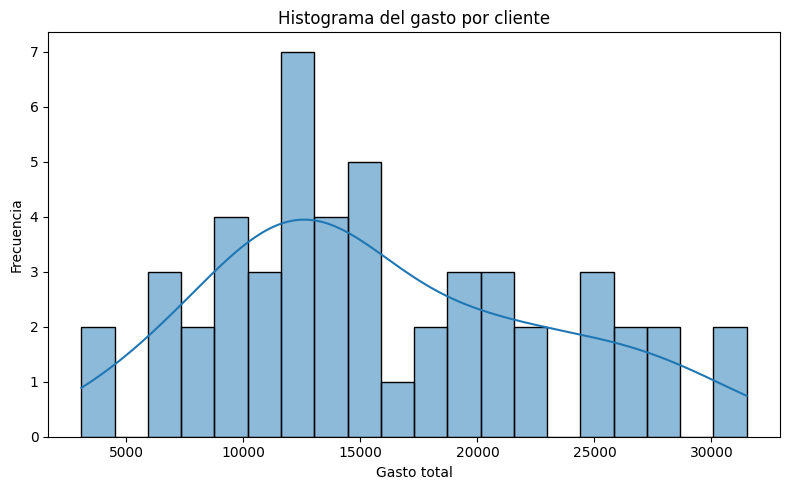

Histograma del gasto por cliente generado.


In [ ]:


if not df_avanzado.empty:
   
    gasto_cliente = df_avanzado.groupby('id_customer')['item_revenue'].sum()

    plt.figure(figsize=(8,5))
    sns.histplot(gasto_cliente, bins=20, kde=True)
    plt.title("Histograma del gasto por cliente")
    plt.xlabel("Gasto total")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()
    print("Histograma del gasto por cliente generado.")

## 12. Visualizacion: Distribucion de ventas por categoria

En este bloque se genera un **boxplot (diagrama de caja)** que muestra la **distribucion de las ventas por categoria de producto**.  
El objetivo es identificar la variabilidad y posibles valores atipicos en los ingresos generados por cada categoria.  

El boxplot permite observar:
- La **mediana** del valor de ventas dentro de cada categoria.  
- El **rango intercuartilico (IQR)**, que representa la dispersion del 50% central de los valores.  
- Los **outliers (valores extremos)**, que pueden indicar productos o transacciones excepcionales.  

Esta visualizacion es util para detectar diferencias en el comportamiento de ventas entre categorias, asi como para evaluar la consistencia del rendimiento dentro de cada una.


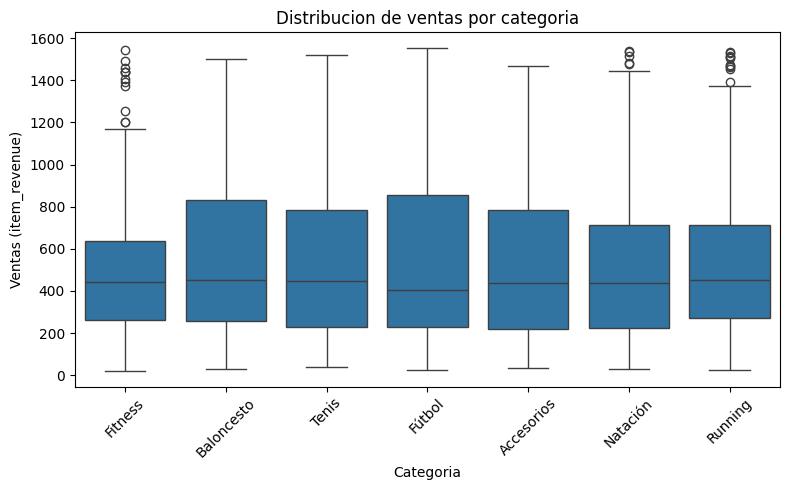

Boxplot de ventas por categoria generado.


In [66]:
if not df_avanzado.empty:
 
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df_avanzado, x='category_name', y='item_revenue')
    plt.title("Distribucion de ventas por categoria")
    plt.xlabel("Categoria")
    plt.ylabel("Ventas (item_revenue)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("Boxplot de ventas por categoria generado.")

## 13. Visualizacion de los productos y categorias mas vendidos

En este bloque se presentan dos graficos de barras que permiten identificar los elementos con mayor impacto en las ventas totales.  

1. **Top 5 categorias por ventas:**  
   Se agrupan los datos por nombre de categoria y se suman los ingresos totales (`item_revenue`) para determinar las cinco categorias que generan el mayor volumen de ventas.  
   Este analisis es util para reconocer las lineas de producto que concentran la mayor parte del ingreso y sirven como motor principal del negocio.

2. **Top 5 productos por ventas:**  
   De forma similar, se agrupan los datos por nombre de producto y se seleccionan los cinco con mayores ingresos totales.  
   Este resultado permite identificar los articulos individuales mas vendidos y evaluar si el portafolio de productos esta concentrado en pocos articulos o si las ventas estan distribuidas de manera uniforme.  

Ambas visualizaciones ayudan a orientar decisiones comerciales relacionadas con inventario, marketing y promociones, priorizando las categorias y productos de mayor rendimiento.


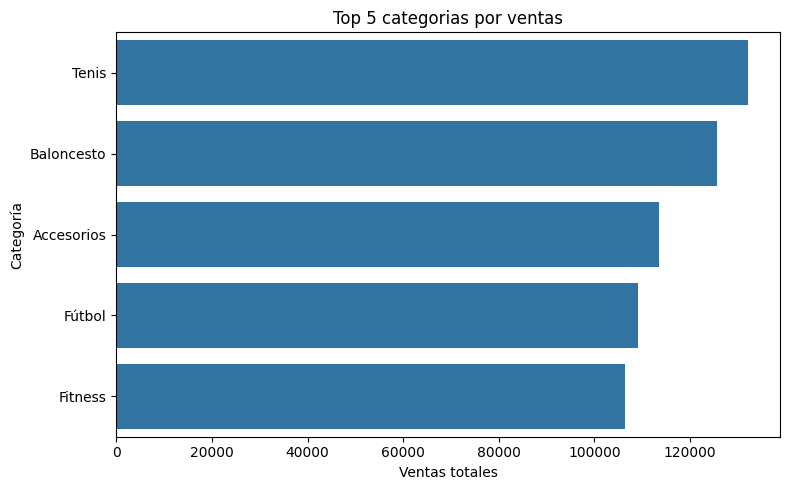

Grafico de barras: Top 5 categorias por ventas generado.


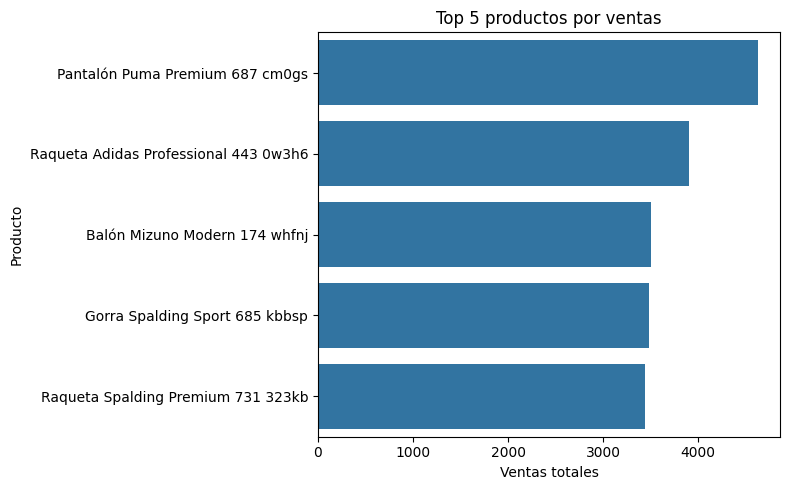

Grafico de barras: Top 5 productos por ventas generado.


In [67]:
if not df_avanzado.empty:
    # Top 5 categorias por ventas
    
    top5_categorias = (
        df_avanzado.groupby('category_name')['item_revenue']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    plt.figure(figsize=(8,5))
    sns.barplot(x=top5_categorias.values, y=top5_categorias.index)
    plt.title("Top 5 categorias por ventas")
    plt.xlabel("Ventas totales")
    plt.ylabel("Categoría")
    plt.tight_layout()
    plt.show()
    print("Grafico de barras: Top 5 categorias por ventas generado.")

   
    # Top 5 productos por ventas
   
    top5_productos = (
        df_avanzado.groupby('product_name')['item_revenue']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    plt.figure(figsize=(8,5))
    sns.barplot(x=top5_productos.values, y=top5_productos.index)
    plt.title("Top 5 productos por ventas")
    plt.xlabel("Ventas totales")
    plt.ylabel("Producto")
    plt.tight_layout()
    plt.show()
    print("Grafico de barras: Top 5 productos por ventas generado.")

## 14. Segmentacion exploratoria por ciudad y categoria

En este bloque se realiza un analisis exploratorio para comprender el comportamiento de las ventas desde una doble perspectiva: **geografica** (por ciudad) y **comercial** (por categoria de producto).  
El objetivo es identificar patrones de compra, diferencias regionales y categorias con mayor contribucion a los ingresos totales.  

El analisis se desarrolla en tres niveles:

1. **Por ciudad:**  
   Se calculan metricas clave como el total de ingresos, numero de pedidos, clientes unicos y ticket promedio por ciudad.  
   Esto permite evaluar que regiones generan mas volumen de ventas y cuales presentan oportunidades de crecimiento.

2. **Por categoria:**  
   Se agrupan las ventas por categoria de producto para medir ingresos totales, cantidad de productos vendidos y precio promedio.  
   Este paso ayuda a identificar las lineas de producto mas exitosas y su impacto general en los ingresos.

3. **Por combinacion ciudad-categoria:**  
   Se integran ambas dimensiones para analizar en que ciudades cada categoria tiene mejor desempeno.  
   Finalmente, se visualiza esta relacion mediante un **mapa de calor (heatmap)** que muestra la distribucion de los ingresos por ciudad y categoria.  

Este analisis es fundamental para la segmentacion del mercado y para el diseño de estrategias de marketing y distribucion adaptadas a cada region.



 Segmentacion exploratoria por ciudad y categoria

--- Segmentación por Ciudad ---
          total_ingresos  pedidos  clientes  promedio_ticket
city                                                        
Medellín    389,172.00      248       25         536.05     
Itagüí      214,086.00      130       13         529.92     
Bello       192,744.00      122       12         526.62     

--- Segmentación por Categoria ---
               total_ingresos  productos  promedio_precio  cantidad_total
category_name                                                            
Tenis            132,212.00       126         267.11             497     
Baloncesto       125,623.00       118         276.95             463     
Accesorios       113,500.00       105         258.15             444     
Fútbol           109,016.00        98         257.26             425     
Fitness          106,451.00       118         265.49             412     
Natación         105,556.00       102         264.08     

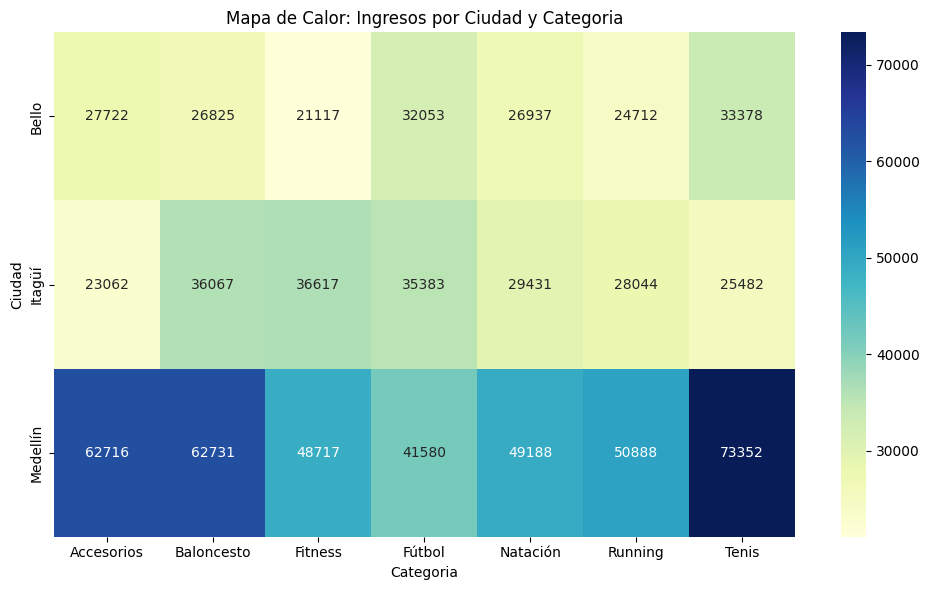

In [68]:
if not df_avanzado.empty:
    print("\n Segmentacion exploratoria por ciudad y categoria")

    # Métricas clave por ciudad
    segmentacion_ciudad = (
        df_avanzado.groupby('city')
        .agg(
            total_ingresos=('item_revenue', 'sum'),
            pedidos=('id_order', 'nunique'),
            clientes=('id_customer', 'nunique'),
            promedio_ticket=('item_revenue', 'mean')
        )
        .sort_values('total_ingresos', ascending=False)
    )

    print("\n--- Segmentación por Ciudad ---")
    print(segmentacion_ciudad.to_string(float_format="{:,.2f}".format))

    # Metricas clave por categoria
    segmentacion_categoria = (
        df_avanzado.groupby('category_name')
        .agg(
            total_ingresos=('item_revenue', 'sum'),
            productos=('product_name', 'nunique'),
            promedio_precio=('unit_price', 'mean'),
            cantidad_total=('quantity', 'sum')
        )
        .sort_values('total_ingresos', ascending=False)
    )

    print("\n--- Segmentación por Categoria ---")
    print(segmentacion_categoria.to_string(float_format="{:,.2f}".format))

    # Combinacion de ciudad y categoria
    segmentacion_combinada = (
        df_avanzado.groupby(['city', 'category_name'])
        .agg(
            total_ingresos=('item_revenue', 'sum'),
            cantidad_total=('quantity', 'sum'),
            promedio_precio=('unit_price', 'mean')
        )
        .reset_index()
        .sort_values('total_ingresos', ascending=False)
    )

    print("\n--- Segmentacion combinada (Ciudad + Categoria) ---")
    print(segmentacion_combinada.head(10).to_string(float_format="{:,.2f}".format))
        # Crear tabla pivote para heatmap
    pivot_heatmap = segmentacion_combinada.pivot_table(
        index='city',
        columns='category_name',
        values='total_ingresos',
        aggfunc='sum',
        fill_value=0
    )

    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_heatmap, cmap='YlGnBu', annot=True, fmt=".0f")
    plt.title("Mapa de Calor: Ingresos por Ciudad y Categoria")
    plt.xlabel("Categoria")
    plt.ylabel("Ciudad")
    plt.tight_layout()
    plt.show()



else:
    print("No hay datos disponibles para realizar segmentacion.")

## 15. Insight y recomendacion

**Insight:**  
El analisis revela la existencia de dos perfiles de consumidor claramente diferenciados:  
- clientes frecuentes con bajo ticket promedio, que generan volumen constante pero menor rentabilidad por pedido,  
- y compradores premium con alto gasto por transaccion, que aportan un porcentaje significativo de los ingresos totales.  

**Recomendacion:**  
Implementar estrategias diferenciadas de marketing y fidelizacion:  
- para el segmento frecuente, ofrecer **programas de puntos, descuentos escalonados o promociones por recurrencia** que incentiven el aumento del ticket promedio;  
- para el segmento premium, desarrollar **beneficios exclusivos, acceso anticipado a lanzamientos y experiencias personalizadas**, reforzando su lealtad y aumentando el valor de vida del cliente.  

Esta estrategia dual permite maximizar la retencion y el ingreso promedio por cliente, optimizando tanto el volumen como la rentabilidad del negocio.
